In [1]:
####################################################################
#                     Practica No.3 - JAGS
# Pregunta 1
####################################################################

#install.packages("R2jags")
#install.packages("mcmctab")

library(foreign)
library(R2jags)
library(coda)
library(boot)
library(mcmcplots)

Warning message:
"package 'R2jags' was built under R version 3.4.4"Loading required package: rjags
Warning message:
"package 'rjags' was built under R version 3.4.4"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs

Attaching package: 'R2jags'

The following object is masked from 'package:coda':

    traceplot

Warning message:
"package 'mcmcplots' was built under R version 3.4.4"

In [2]:
#Ruta archivo
PATH.FILE <- "https://raw.githubusercontent.com/jgomezz/MscEstadisticaAplicada-UNALM-2018-2/master/MLG/Practica-03/molinos.csv"

#Lectura de datos
molinos.data <- read.csv(PATH.FILE, header = TRUE)
head(molinos.data)

viento,corriente
5.0,1.582
6.0,1.822
3.4,1.057
2.7,0.500
10.0,2.236
9.7,2.386


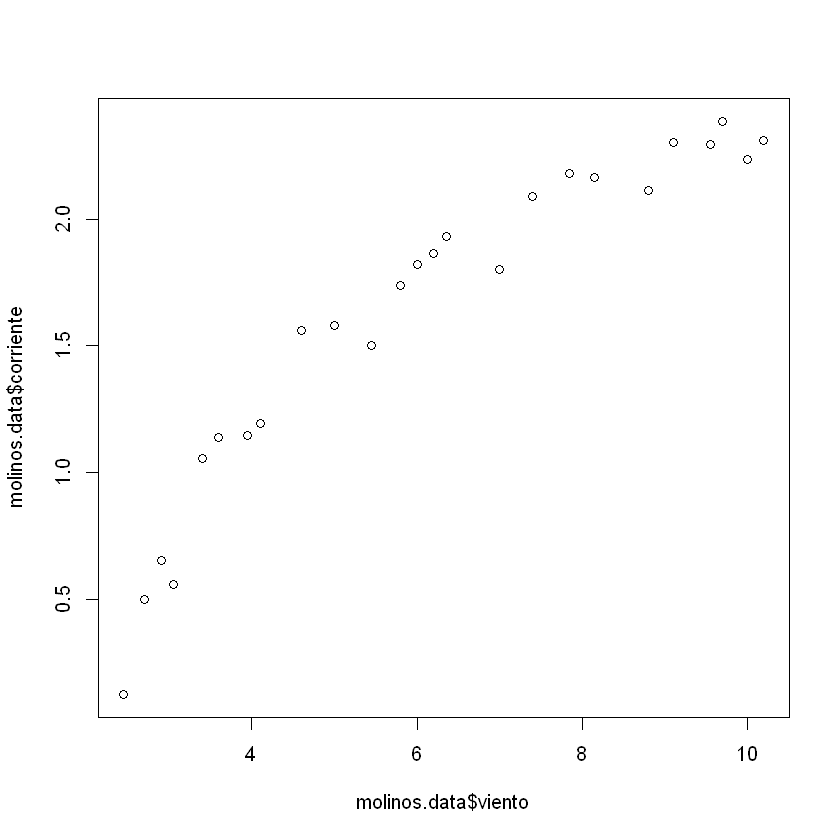

In [3]:
#Análisis descriptivo
plot(molinos.data$viento, molinos.data$corriente)

In [4]:
#Datos para el análisis
molinos.data.bugs <- list(viento = molinos.data$viento ,
                          corriente = molinos.data$corriente ,
                          N = nrow(molinos.data))

# Parametros
molinos.param.bugs <- c("alpha","beta1","tau","sigma2")


# Inicializa : asigna valores aleatorios para inicializarlos
molinos.inits.bugs <- function() {
                        list( alpha = rnorm(1), 
                              beta1 = rnorm(1), 
                              tau   = rgamma(1,1,1) )}

In [5]:
####################################################################
# Modelo Lineal Normal - Modelo 1 : Eta_i= Beta_0 + Beta_1*x_i
####################################################################

# Inferencia Clásica
molinos.model.1.clasic<-lm(molinos.data$corriente ~ molinos.data$viento)
summary(molinos.model.1.clasic)


Call:
lm(formula = molinos.data$corriente ~ molinos.data$viento)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59869 -0.14099  0.06059  0.17262  0.32184 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.13088    0.12599   1.039     0.31    
molinos.data$viento  0.24115    0.01905  12.659 7.55e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2361 on 23 degrees of freedom
Multiple R-squared:  0.8745,	Adjusted R-squared:  0.869 
F-statistic: 160.3 on 1 and 23 DF,  p-value: 7.546e-12


In [6]:
# Aplicando Bayesianos
molinos.model.1.jags <- function(){
    # verosimilitud
    for (i in 1:N) {
      mu[i] <- alpha + beta1*viento[i];
      corriente[i] ~ dnorm(mu[i],tau);
    }

    alpha  ~ dnorm(0.0,1.0E-4);      # 1er parametro  
    beta1  ~ dnorm(0.0,1.0E-4);      # 2do parametro
    tau    ~ dgamma(1.0E-3,1.0E-3);  # 3er parametro , la precisión , uso gamma 
    
    # con valores pequeño para tener una varianza grande
    sigma2 <- 1/tau;
}

# Inferencia Bayesiana
molinos.fit.model.1.bugs <- jags(data=molinos.data.bugs, 
                                 inits=molinos.inits.bugs, 
                                 molinos.param.bugs, 
                                 n.chains=2, 
                                 n.iter=20000, 
                                 n.burnin=10000, 
                                 model.file=molinos.model.1.jags)

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25
   Unobserved stochastic nodes: 3
   Total graph size: 109

Initializing model



In [7]:
#Mostrar resultados de la simulación
print(molinos.fit.model.1.bugs,4)

Inference for Bugs model at "C:/WINDOWS/TEMP/RtmpEHAEad/model2f3f43f794092.txt", fit using jags,
 2 chains, each with 20000 iterations (first 10000 discarded), n.thin = 10
 n.sims = 2000 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%   Rhat n.eff
alpha     0.1253  0.1431 -0.1497  0.0376  0.1262  0.2117  0.3888 1.0010  2000
beta1     0.2418  0.0211  0.2020  0.2285  0.2422  0.2551  0.2821 1.1429  2000
sigma2    0.0616  0.0329  0.0342  0.0475  0.0571  0.0704  0.1081 1.0026   730
tau      17.9395  5.2554  9.2469 14.2070 17.5121 21.0667 29.2702 1.0026   730
deviance -0.0475  3.2458 -3.0957 -2.0737 -0.7882  0.9921  6.9706 1.0006  2000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 5.3 and DIC = 5.2
DIC is an estimate of expected predictive error (lower deviance is better).


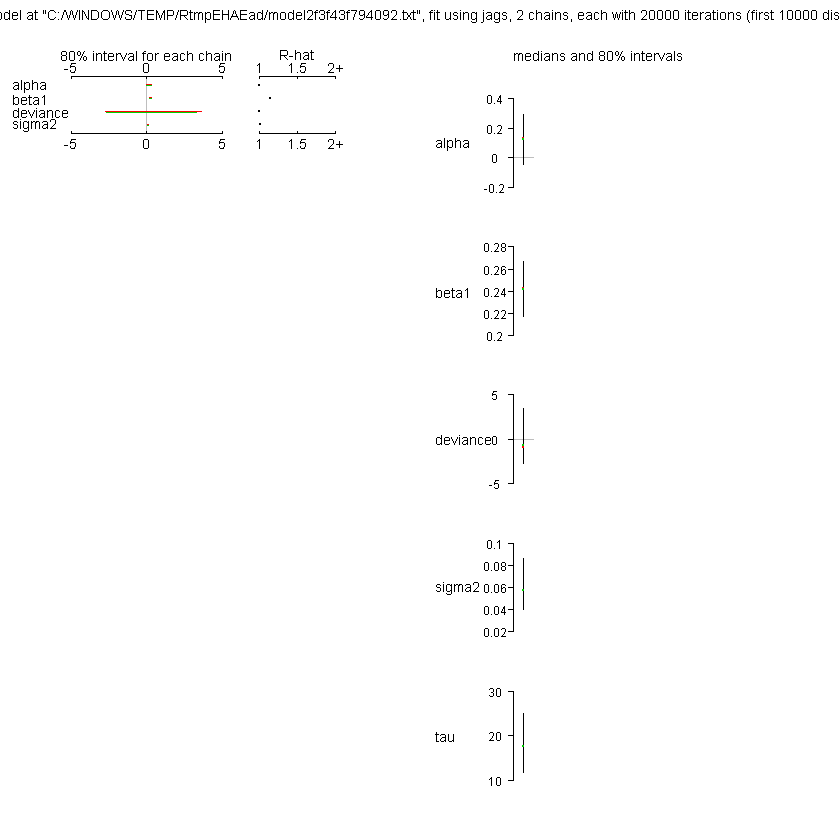

In [8]:
#Diagnostico de Convergencia
plot(molinos.fit.model.1.bugs)

In [9]:
####################################################################
# Modelo Lineal Normal - Modelo 2 : Eta_i= Beta_0 + Beta_1*1/x_i
####################################################################

# Inferencia Clásica
molinos.model.2.clasic<-lm(molinos.data$corriente ~ I(1/molinos.data$viento))
summary(molinos.model.2.clasic)


Call:
lm(formula = molinos.data$corriente ~ I(1/molinos.data$viento))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20547 -0.04940  0.01100  0.08352  0.12204 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                2.9789     0.0449   66.34   <2e-16 ***
I(1/molinos.data$viento)  -6.9345     0.2064  -33.59   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09417 on 23 degrees of freedom
Multiple R-squared:   0.98,	Adjusted R-squared:  0.9792 
F-statistic:  1128 on 1 and 23 DF,  p-value: < 2.2e-16


In [10]:
# Aplicando Bayesianos
molinos.model.2.jags <- function(){
  # verosimilitud
  for (i in 1:N) {
    mu[i] <- alpha + beta1*(1/viento[i]);
    corriente[i] ~ dnorm(mu[i],tau);
  }
  
  alpha  ~ dnorm(0.0,1.0E-4);      # 1er parametro  
  beta1  ~ dnorm(0.0,1.0E-4);      # 2do parametro
  tau    ~ dgamma(1.0E-3,1.0E-3);  # 3er parametro , la precisión , uso gamma 
  
  # con valores pequeño para tener una varianza grande
  sigma2 <- 1/tau;
}

# Inferencia Bayesiana
molinos.fit.model.2.bugs <- jags(data=molinos.data.bugs, 
                                 inits=molinos.inits.bugs, 
                                 molinos.param.bugs, 
                                 n.chains=2, 
                                 n.iter=20000, 
                                 n.burnin=10000, 
                                 model.file=molinos.model.2.jags)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25
   Unobserved stochastic nodes: 3
   Total graph size: 134

Initializing model



In [11]:
#Mostrar resultados de la simulación
print(molinos.fit.model.2.bugs,4)

Inference for Bugs model at "C:/WINDOWS/TEMP/RtmpEHAEad/model2f3f4ca91dee.txt", fit using jags,
 2 chains, each with 20000 iterations (first 10000 discarded), n.thin = 10
 n.sims = 2000 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%   Rhat
alpha      2.9803  0.0574   2.8880   2.9478   2.9802   3.0097   3.0703 1.0207
beta1     -6.9408  0.2570  -7.3715  -7.0779  -6.9362  -6.7949  -6.5313 1.0367
sigma2     0.0100  0.0141   0.0054   0.0075   0.0092   0.0113   0.0175 1.0158
tau      112.5335 33.6029  57.1744  88.4714 108.8333 133.4910 184.4616 1.0158
deviance -46.0436  3.3852 -49.0012 -47.9752 -46.6512 -44.9549 -39.7631 1.0851
         n.eff
alpha     2000
beta1     2000
sigma2     490
tau        490
deviance  1100

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 5.7 and DIC = -40.3
DIC is an estimate

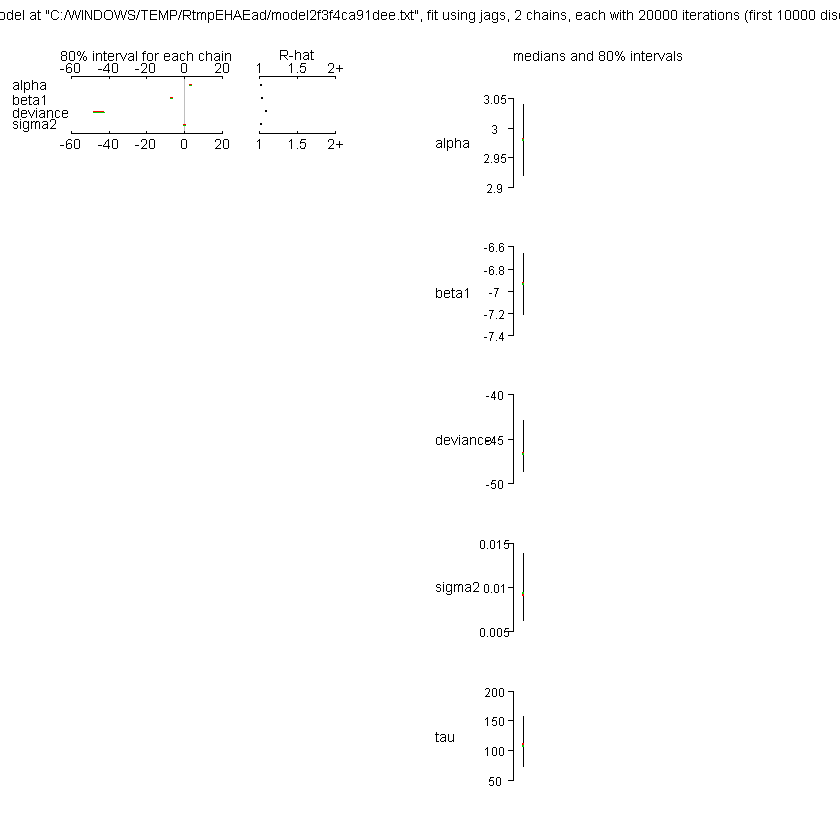

In [12]:
#Diagnostico de Convergencia
plot(molinos.fit.model.2.bugs)

In [13]:
####################################################################
# Modelo Lineal Normal - Modelo 3 : Eta_i= Beta_0 + Beta_1*log(x_i)
####################################################################

# Inferencia Clásica
molinos.model.3.clasic<-lm(molinos.data$corriente ~ I(log(molinos.data$viento)))
summary(molinos.model.3.clasic)


Call:
lm(formula = molinos.data$corriente ~ I(log(molinos.data$viento)))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31619 -0.07685  0.02395  0.11139  0.23029 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.83036    0.11083  -7.493  1.3e-07 ***
I(log(molinos.data$viento))  1.41677    0.06234  22.728  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1376 on 23 degrees of freedom
Multiple R-squared:  0.9574,	Adjusted R-squared:  0.9555 
F-statistic: 516.6 on 1 and 23 DF,  p-value: < 2.2e-16


In [14]:
# Aplicando Bayesianos
molinos.model.3.jags <- function(){
  # verosimilitud
  for (i in 1:N) {
    mu[i] <- alpha + beta1*log(viento[i]);
    corriente[i] ~ dnorm(mu[i],tau);
  }
  
  alpha  ~ dnorm(0.0,1.0E-4);      # 1er parametro  
  beta1  ~ dnorm(0.0,1.0E-4);      # 2do parametro
  tau    ~ dgamma(1.0E-3,1.0E-3);  # 3er parametro , la precisión , uso gamma 
  
  # con valores pequeño para tener una varianza grande
  sigma2 <- 1/tau;
}

# Inferencia Bayesiana
molinos.fit.model.3.bugs <- jags(data=molinos.data.bugs, 
                                 inits=molinos.inits.bugs, 
                                 molinos.param.bugs, 
                                 n.chains=2, 
                                 n.iter=20000, 
                                 n.burnin=10000, 
                                 model.file=molinos.model.3.jags)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25
   Unobserved stochastic nodes: 3
   Total graph size: 134

Initializing model



In [15]:
#Mostrar resultados de la simulación
print(molinos.fit.model.3.bugs,4)

Inference for Bugs model at "C:/WINDOWS/TEMP/RtmpEHAEad/model2f3f45e167d32.txt", fit using jags,
 2 chains, each with 20000 iterations (first 10000 discarded), n.thin = 10
 n.sims = 2000 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%   Rhat
alpha     -0.8303  0.1241  -1.0467  -0.9024  -0.8288  -0.7557  -0.6031 1.0168
beta1      1.4174  0.0781   1.2927   1.3749   1.4171   1.4585   1.5447 1.0141
sigma2     0.0218  0.0572   0.0115   0.0160   0.0195   0.0238   0.0366 1.0138
tau       53.0540 15.5090  27.3087  41.9946  51.1920  62.3114  87.3051 1.0138
deviance -27.1399  3.6189 -30.0871 -28.9827 -27.8262 -26.1140 -20.4598 1.0981
         n.eff
alpha      950
beta1     1200
sigma2    1000
tau       1000
deviance  2000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 6.5 and DIC = -20.6
DIC is an estimat

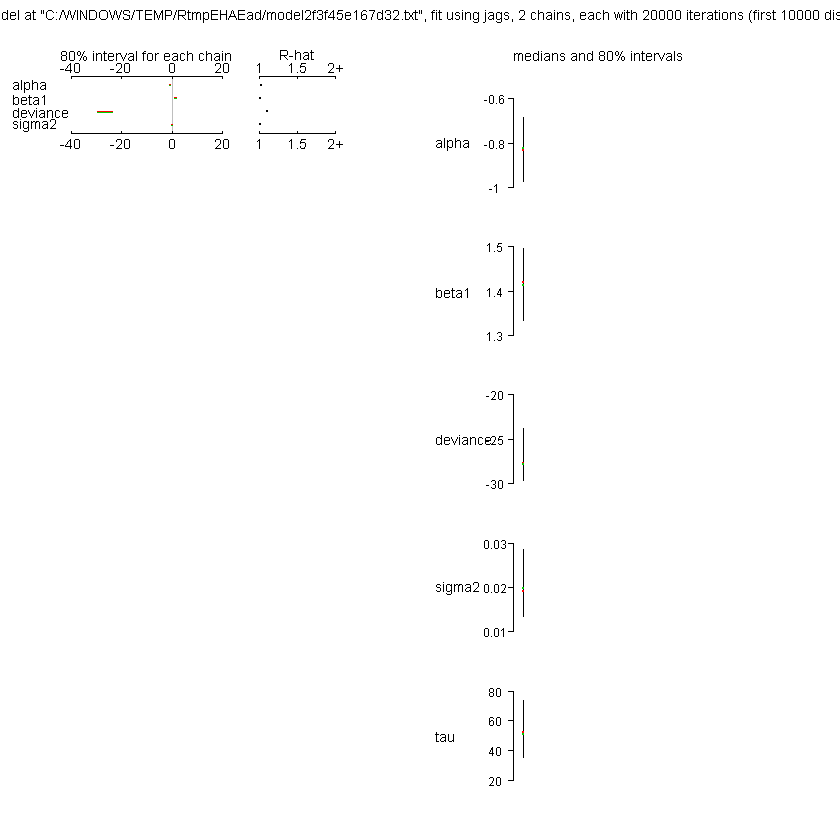

In [16]:
#Diagnostico de Convergencia
plot(molinos.fit.model.3.bugs)

In [17]:
# Comparación de los modelos basados en el DIC : Deviance Information Criterion
df <- data.frame(
  modelo = c(" Modelo 1",
             " Modelo 2",
             " Modelo 3"),
  DIC = c(molinos.fit.model.1.bugs$BUGSoutput$DIC,
          molinos.fit.model.2.bugs$BUGSoutput$DIC,
          molinos.fit.model.3.bugs$BUGSoutput$DIC)
)

df[order(df$DIC),]

,modelo,DIC
2,Modelo 2,-40.316216
3,Modelo 3,-20.590857
1,Modelo 1,5.222298
